# Watermark Remover
Apply the Fast Gradient Sign Method to remove watermarks from meta generated images.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

import utils_img
import utils

In [2]:
device = 'cpu'
#epsilons = [0, .05, .1, .15, .2, .25, .3]
epsilons = [0, .01, .05, .1]
# Set random seed for reproducibility
torch.manual_seed(42)
# Load the classifier generated from meta-classifier.ipynb
model = torch.jit.load("models/meta_classifier.pt").to(device)

In [3]:
img_size = 256

# augment training set with some transformations 
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(img_size),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=180),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]) # default for pytorch, based on imagenet 
])

val_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
    transforms.Resize(512),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [4]:
from torch.utils.data import DataLoader, Subset
from torchvision.datasets.folder import default_loader
from torch.nn.utils.rnn import pad_sequence
import numpy as np 

batch_size = 1
# 2370 meta, 2400 from Coco2017
train_dir = "data/meta/train"
train_size = 2370

# 296 meta, 300 from Coco2017
val_dir = "data/meta/val"
val_size = 296

class ImageFolder:
    """An image folder dataset intended for supervised learning."""

    def __init__(self, path, transform=None, loader=default_loader):
        # ignore directories with previously augmented images
        self.samples = [x for x in utils.get_image_paths(path) if not "orig" in x]
        self.loader = loader
        self.transform = transform

    def __getitem__(self, idx: int):
        """
        Returns the image with its corresponding label. Images are 
        labeled 0 if the image is not watermarked, else 1. 
        """
        assert 0 <= idx < len(self)
        path = self.samples[idx]
        img = self.loader(path)
        label = 0 if "orig" in path else 1
        if self.transform:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.samples)


def get_dataloader(data_dir, transform, batch_size=128, num_imgs=None, shuffle=False, num_workers=4):
    """ Get dataloader for the images in the data_dir. """
    dataset = ImageFolder(data_dir, transform=transform)
    if num_imgs is not None:
        dataset = Subset(dataset, np.random.choice(len(dataset), num_imgs, replace=False))
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, pin_memory=True, drop_last=True, collate_fn=None)


train_loader = get_dataloader(train_dir, test_transform, batch_size, num_imgs=5, shuffle=True)

# can try validate with image augmentations (train_transform) or without (val_transform)
val_loader = get_dataloader(val_dir, val_transform, batch_size, num_imgs=val_size, shuffle=True)


Apply the Fast Gradient Sign Method (FGSM) permutate generated images to fool the watermark classifier. 

In [8]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

def norm(data):
    trans = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    return trans(data)

# restores the tensors to their original scale
def denorm(data):
    """
    Convert a batch of tensors to their original scale.

    Args:
        batch (torch.Tensor): Batch of normalized tensors.
        mean (torch.Tensor or list): Mean used for normalization.
        std (torch.Tensor or list): Standard deviation used for normalization.

    Returns:
        torch.Tensor: batch of tensors without normalization applied to them.
    """
    trans = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225]) # Unnormalize (x * std) + mean
    return trans(data)

In [6]:
for data, target in train_loader:
    data = data.to(device)
    output = model(data)
    init_pred = torch.sigmoid(output).round().cpu().detach().numpy().squeeze()
    print(init_pred.item())
    print(target.cpu().detach().numpy().squeeze())
    print(init_pred.item()  == target)
    break

1.0
1
tensor([True])


In [7]:
# ref: https://pytorch.org/tutorials/beginner/fgsm_tutorial.html
def test( model, device, test_loader, epsilon ):
    model.eval()
    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device, dtype=torch.float), target.to(device, dtype=torch.float)
        
        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        output = output.squeeze(0)
        init_pred = torch.sigmoid(output).round()
        # If the initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.binary_cross_entropy_with_logits(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect ``datagrad``
        data_grad = data.grad.data

        # Restore the data to its original scale
        data_denorm = denorm(data)

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)

        # Reapply normalization
        perturbed_data_normalized = norm(perturbed_data)

        # Re-classify the perturbed image
        output = model(perturbed_data_normalized)

        # Check for success
        final_pred = torch.sigmoid(output).round().detach() # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu()
                #transforms.ToPILImage()(adv_ex).show() 
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
    # Calculate final accuracy for tnll_losshis epsilon
    final_acc = correct/float(len(test_loader))
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader)} = {final_acc}")

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples


In [8]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, train_loader, eps)
    accuracies.append(acc)
    examples.append(ex)


Epsilon: 0	Test Accuracy = 5 / 5 = 1.0
Epsilon: 0.01	Test Accuracy = 0 / 5 = 0.0
Epsilon: 0.05	Test Accuracy = 0 / 5 = 0.0
Epsilon: 0.1	Test Accuracy = 0 / 5 = 0.0


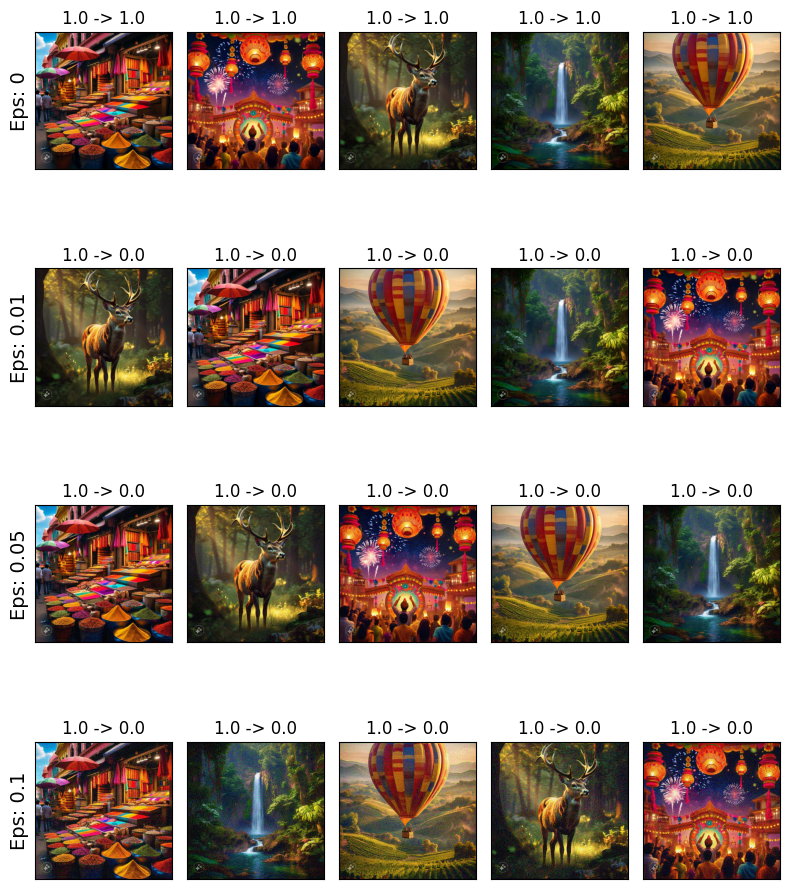

In [9]:
from PIL import Image

# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(transforms.ToPILImage()(ex))
plt.tight_layout()
plt.show()


In [10]:
from torchvision.utils import save_image

for i in range(len(epsilons)):
    eps = epsilons[i]
    for j in range(len(examples[i])):
        save_image(examples[i][j][2], f"images/test/e{eps}_{j}.png")

In [ ]:
transforms.ToPILImage()(examples[1][4][2]).show()

Apply DeepFool algorithm to remove watermarks

In [13]:
import numpy as np
from torch.autograd import Variable
import copy

device = 'cuda'

def deepfool(data, model, max_iter=50):
    '''
    Implementation of deepfool for binary classifier. 
    Ref: https://openaccess.thecvf.com/content_cvpr_2016/papers/Moosavi-Dezfooli_DeepFool_A_Simple_CVPR_2016_paper.pdf
    params: 
        data: (normalized image, original label)
        model: classifier to label normalized image
    returns:
        total pertubation, adversarial image, original image, classifier prediction of adversarial image
    '''
    model.eval()
    examples = []
    i = 0 
    img, target = data
    model = model.to(device)
    img, target = img.to(device, dtype=torch.float), target.to(device, dtype=torch.float)
    adv_img = copy.deepcopy(img)
    r_tot = np.zeros(img.shape)
    
    # Set requires_grad attribute of tensor. Important for Attack
    adv_img.requires_grad = True    
    output = model.forward(adv_img)
    pred = torch.sigmoid(output.squeeze(0)).round()

    while pred.item() == target.item() and i < max_iter:
        output.backward(retain_graph=True)
        
        grad = adv_img.grad.data.cpu().numpy().copy()
        adv_img.grad.zero_()
        
        # r = -f(x) * grad(f(x)) / (magnitude(grad(f(x)))^2)
        r_i =  (-1 * pred.item() * grad) / (np.linalg.norm(grad.flatten()) ** 2)
        r_tot = np.float32(r_tot + r_i)
        adv_img.data = adv_img.data + torch.from_numpy(r_i).to(device)
        
        output = model.forward(adv_img)
        pred = torch.sigmoid(output.squeeze(0)).round()
        i += 1
        
    # denorm to convert images back to original scale
    adv_img = denorm(adv_img.squeeze().detach().cpu())
    adv_img = torch.clamp(adv_img, 0, 1)
    img = denorm(img.squeeze().cpu())
    img = torch.clamp(img, 0, 1)
    return r_tot, adv_img, img, pred.item()


In [14]:
examples = []

for data in train_loader:
    r_tot, pert, orig, pred = deepfool(data, model)
    if pred == 0:
        # successfully misclassified
        examples.append((r_tot, pert, orig))

#transforms.ToPILImage()(torch.clamp(pert, 0, 1)).show()

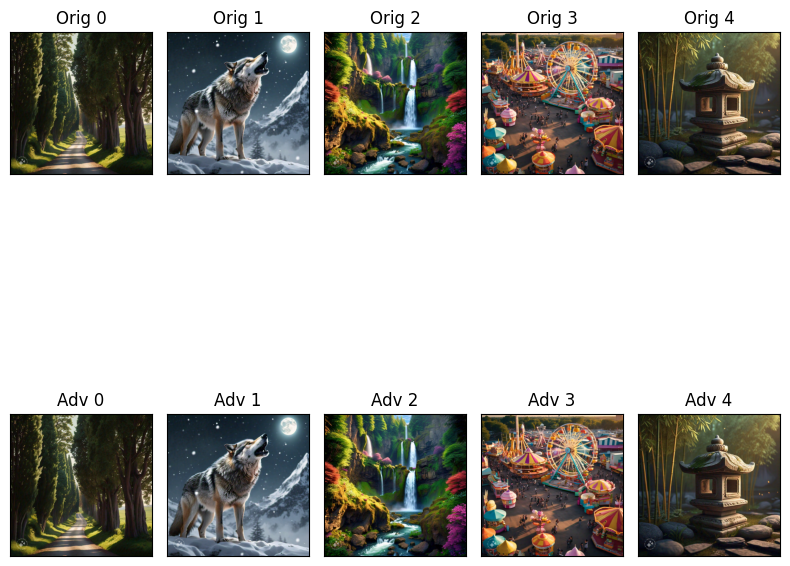

In [15]:
from PIL import Image

plt.figure(figsize=(8,10))
for i in range(len(examples)):
    r, pert, ori = examples[i]
    plt.subplot(2, len(examples), i+1)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title(f"Orig {i}")
    plt.imshow(transforms.ToPILImage()(orig))
    
    plt.subplot(2, len(examples), len(examples)+i+1)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title(f"Adv {i}")
    plt.imshow(transforms.ToPILImage()(pert))
plt.tight_layout()
plt.show()



In [186]:
from torchvision.utils import save_image

for i in range(len(examples)):
    _, pert, _ = examples[i]
    save_image(pert, f"images/test/deepfool_{i}.png")